### IBM Employee Churn Prediction Model
##### ---- Sourav Sinha, PhD Economics Candidate, Yale University

_______________________________________________________________________________________________________________________________
#### # Project Goals: 
Predict employee churn (employee exits) using labelled data on employee and job characteristics

#### # Data Analyses Methods (in order of application):
1.   Data Wrangling and Feature Generation
    *   Check data types and convert into appropriate types.
    *   Check for missing values in columns and impute, if any.
    *   Rename levels of categorical type variables to enhance interpretability.
    *   Drop irrelevant and redundant columns from raw dataset.
2.   Exploratory Data Analyses
    *   Frequency Distribution of outcome variable.
    *   Tabulation and Visualization of summary statistics by one or more numeric and categorical features.
    *   Linear and Logistic Regression to interpret relation between outcome and feature variables.
    *   K-Means Clustering on features to detect possible clusters of employees.
3.   Predictions using following Classifier Models (with and without hyperparameter tuning):
    *   Logistic Regression
    *   Gradient Boosting
    *   Random Forest
    *   Neural Networks in Tensorflow
4.   Generate Prediction Metrics for each model and compare across models  


In [158]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import chardet
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import heapq
import re
import plotnine
import copy
import pydot
import graphviz
import datetime
import jinja2
import itertools
from graphviz import Source
from scipy.stats import randint as sp_randint
import scipy.stats
from scipy.stats import skew, shapiro, ttest_ind, levene, wilcoxon, ranksums, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.inspection import plot_partial_dependence, partial_dependence
from IPython.display import display
from pprint import pprint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorboard.plugins.hparams import api as hp

In [3]:
## Importing raw data into notebook

# Define paths to raw data, processed data, and graphs to be generated 
sourcepath = "D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm"
rawdatapath = os.path.join(sourcepath, 'data', 'raw')
finaldatapath = os.path.join(sourcepath, 'data', 'processed')
graphpath = os.path.join(sourcepath, 'reports', 'figures')
rawfilename = 'IBM HR Analytics.csv'
finalfilename = 'IBM_HR_Analytics_Processed.csv'

# Detecting encoding (if any) of the raw data file
rawdata = open(os.path.join(rawdatapath, rawfilename), 'rb').read()
result = chardet.detect(rawdata)
charenc = result['encoding']

# Load raw data into notebook using the encoding in 'charenc' 
IBMData = pd.read_csv(os.path.join(rawdatapath, rawfilename), encoding = charenc)

# Delete any redundant objects
del [rawdata, result, charenc, rawdatapath, rawfilename]

### (Step 1) Data Wrangling and Feature Correction

#### Methods Used:
* Column Data Types and Type Conversion
* Shape of Data Frame
* Checks for NULL and/or NaN values in columns and imputations, if required
* Drop Redundant and Irrelevant Columns 

In this section, we first explore the features in the raw datasets and their data types. Then, depending on how we interpret 
the feature we change the data types of the columns. We also note the number of observations in the data and the presence of 
NULL or NaN values in any column. If there are missing values, we impute missing values using one of the many imputation 
techniques. Further, we drop columns which have the same value for all observations and also columns which do not contain any 
relevant information. One such column is 'EmployeeNumber' which we can drop because it contains unique IDs for each employee 
and each employee features in our raw dataset only once. 

In [4]:
# (0) Visualizing dataframe head

IBMData.head(n=5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [5]:
# (1) Variable names and their data types
# print('Variable Names and Data Types:\n')
# print(IBMData.dtypes)

# (2) Number of observations
#print('-----------------------------------------------------------------------------------------------------------------------')
print('\nTotal number of observations in raw dataset: {}'.format(IBMData.shape[0]))

# (3) Check for presence of NULL/NA values in columns
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nChecking for NaN values in dataframe columns....\n')
[print(x, IBMData[x].isna().sum()) for x in IBMData.columns if IBMData[x].isna().sum() > 0] # print colname and # of NaN values
if(~IBMData.isna().sum().sum()): print('Raw data has no NaN values.\n')     
print('Checking for Null values in dataframe columns....\n')
[print(IBMData[x].isnull().sum()) for x in IBMData.columns if IBMData[x].isnull().sum() > 0] # print colname and # of Null values
if(~IBMData.isnull().sum().sum()): print('Raw data has no Null values.\n')     
print('--- No imputations required.')

# (4) Drop columns which have no variation across rows
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nDropping columns which have no variation across rows...\n')
for x in IBMData.columns:
    if(IBMData[x].nunique()==1): # check if the number of unique values == 1
        print('Column dropped: {}'.format(str(x)))
        IBMData.drop([x], axis = 1, inplace = True) # adjust the dataframe inplace by dropping the column 
        
# (5) Drop columns which have irrelevant information (like unique IDs)

# We drop the column 'EmployeeNumber' since it contains unique IDs for 
# each employee and we do not observe multiple instances of same employee.
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nDropping Column: "EmployeeNumber" since it has unique ID for each observation...')
IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)


Total number of observations in raw dataset: 1470
-----------------------------------------------------------------------------------------------------------------------

Checking for NaN values in dataframe columns....

Raw data has no NaN values.

Checking for Null values in dataframe columns....

Raw data has no Null values.

--- No imputations required.
-----------------------------------------------------------------------------------------------------------------------

Dropping columns which have no variation across rows...

Column dropped: EmployeeCount
Column dropped: Over18
Column dropped: StandardHours
-----------------------------------------------------------------------------------------------------------------------

Dropping Column: "EmployeeNumber" since it has unique ID for each observation...


### (Step 2) Data Wrangling

* Convert column types into appropriate data types
* Rename levels of 'categorical' variables to improve interpretability

In [6]:
# (1) Convert all columns into one of three types: float, int, category 

# 'Float' type columns include all numeric columns (numvars), as well as some ordinal categorical variables (ordvars)
numvars = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
          'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
ordvars = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',  
          'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

# 'Category' type columns include all categorical variables with no ordinal levels
catvars = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 
           'PerformanceRating', 'MaritalStatus', 'OverTime']

# 'Integer' type columns include the outcome variable 'Attrition'
intvars = ['Attrition']

# Now convert the columns in numvars and ordvars lists to float
print('Converting some columns to "float"...')
#print(numvars + ordvars)
IBMData[numvars + ordvars] = IBMData[numvars + ordvars].apply(pd.to_numeric, downcast = 'float', axis = 1)

# Now convert the columns in catvars to 'category' type
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nConverting some columns to "category"...')
#print(catvars)
IBMData[catvars] = IBMData[catvars].astype('category');

# Now convert the 'Attrition' column to 'integer' type
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nConverting "Attrition" column to'' "integer"...')
exit_map = {'Yes':1, 'No':0} # Use a dictionary since this will be used later
IBMData['Attrition'] = IBMData['Attrition'].map(exit_map);


# (2) Rename levels of some categorical variables:
print('-----------------------------------------------------------------------------------------------------------------------')
print('\nRenaming some levels of some of the categorical variables...')
IBMData['BusinessTravel'].cat.rename_categories({
    'Travel_Rarely':'Rare', 'Travel_Frequently':'Frequent', 'Non-Travel':'No'}, inplace = True)
IBMData['Department'].cat.rename_categories({
    'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories({
    'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'HR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories({
    'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'DirManufac','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'DirResearch','Human Resources':'HR'}, inplace = True)

# (3) Final list of data types and column names
print('-----------------------------------------------------------------------------------------------------------------------')
maxlength = max(len(numvars + ordvars), len(catvars), 1)
typeframe = pd.DataFrame({'Float':numvars+ordvars, 
                          'Category':catvars+['']*(maxlength - len(catvars)),
                          'Integer':['Attrition']+['']*(maxlength - 1)})
print('\nData Types of Feature and Outcome Columns: \n')
print(typeframe)

# Deleting redundant data objects
del [typeframe, maxlength]

Converting some columns to "float"...
-----------------------------------------------------------------------------------------------------------------------

Converting some columns to "category"...
-----------------------------------------------------------------------------------------------------------------------

Converting "Attrition" column to "integer"...
-----------------------------------------------------------------------------------------------------------------------

Renaming some levels of some of the categorical variables...
-----------------------------------------------------------------------------------------------------------------------

Data Types of Feature and Outcome Columns: 

                       Float           Category    Integer
0                        Age     BusinessTravel  Attrition
1                  DailyRate         Department           
2           DistanceFromHome     EducationField           
3                 HourlyRate             Gender  

### (Step 3) Processed Data Exploration

#### (Step 3.a) Exploring Outcome Variable ('Attrition')

* Proportion of workers leaving


#### (Step 3.b) Exploring Feature Variables

* Summary statistics of numeric variables (Table and Visualizations)
* Univariate Frequency Distributions of categorical variables (Table and Visualizations)
* Pairwise scatter plots of numeric variables
* Pairwise scatter plots of numeric variables (with categorical types)
* Summary statistics of numeric variables grouped by categorical types


#### (Step 3.c) Exploring Relationship between Outcome and Feature Variables

#### (Step 3.a) Proportion of employees who leave

Percentage of employees who leave: 16.122%



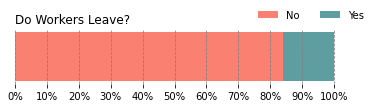

In [7]:
## (A) Exploring Outcome Variable: Attrition

print('Percentage of employees who leave: {:2.3%}\n'.format(IBMData['Attrition'].sum()/len(IBMData)))

# Show graphically the fraction of workers leaving
df_grouped = IBMData['Attrition'].value_counts()/len(IBMData) 
fracLeave = pd.DataFrame({df_grouped.index[0]:[df_grouped[0]], 
                          df_grouped.index[1]:[df_grouped[1]]}) # Create a dataframe with proportion of exits and retains
fracLeave.columns = fracLeave.columns.map(dict(map(reversed, exit_map.items()))) # Change the column names using the map defined 
fields = fracLeave.columns.to_list() # Get a list of the column names
colors = ['salmon', 'cadetblue']
left = len(fracLeave)*[0]

fig, ax = plt.subplots(figsize = (6,1))
for idx, name in enumerate(fields):
    plt.barh(fracLeave.index, fracLeave[name], left = left, color = colors[idx])
    left = left + fracLeave[name]
plt.title('Do Workers Leave?', loc = 'left')
plt.legend(fracLeave.columns.to_list(), ncol = 2, frameon = False, bbox_to_anchor = ([0.7, 1.0, 0., 0.]))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
ax.get_yaxis().set_ticks([])
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

# Delete redundant data objects
del [df_grouped, fracLeave, fields, colors, left, idx, name, fig, ax]

The plot above shows that over 80% of employees do not leave the firm. Only about 16% of employee exit. 

#### (Step 3.b) Summary Statistics of Numeric and Categorical Feature Variables

In [8]:
# (1) Summary Statistics of Numeric Variables

print('Descriptive Summary Statistics of all Numeric Variables:\n')
floatvar_stats = IBMData[numvars + ordvars].describe().transpose()
floatvar_stats

Descriptive Summary Statistics of all Numeric Variables:



,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923809,9.135373,18.0,30.0,36.0,43.00,60.0
DailyRate,1470.0,802.485718,403.509094,102.0,465.0,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106865,1.0,2.0,7.0,14.00,29.0
HourlyRate,1470.0,65.891159,20.329428,30.0,48.0,66.0,83.75,100.0
MonthlyIncome,1470.0,6502.931152,4707.956543,1009.0,2911.0,4919.0,8379.00,19999.0
MonthlyRate,1470.0,14313.103516,7117.786133,2094.0,8047.0,14235.5,20461.50,26999.0
NumCompaniesWorked,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.00,9.0
PercentSalaryHike,1470.0,15.209524,3.659938,11.0,12.0,14.0,18.00,25.0
TotalWorkingYears,1470.0,11.279592,7.780782,0.0,6.0,10.0,15.00,40.0
TrainingTimesLastYear,1470.0,2.799320,1.289271,0.0,2.0,3.0,3.00,6.0


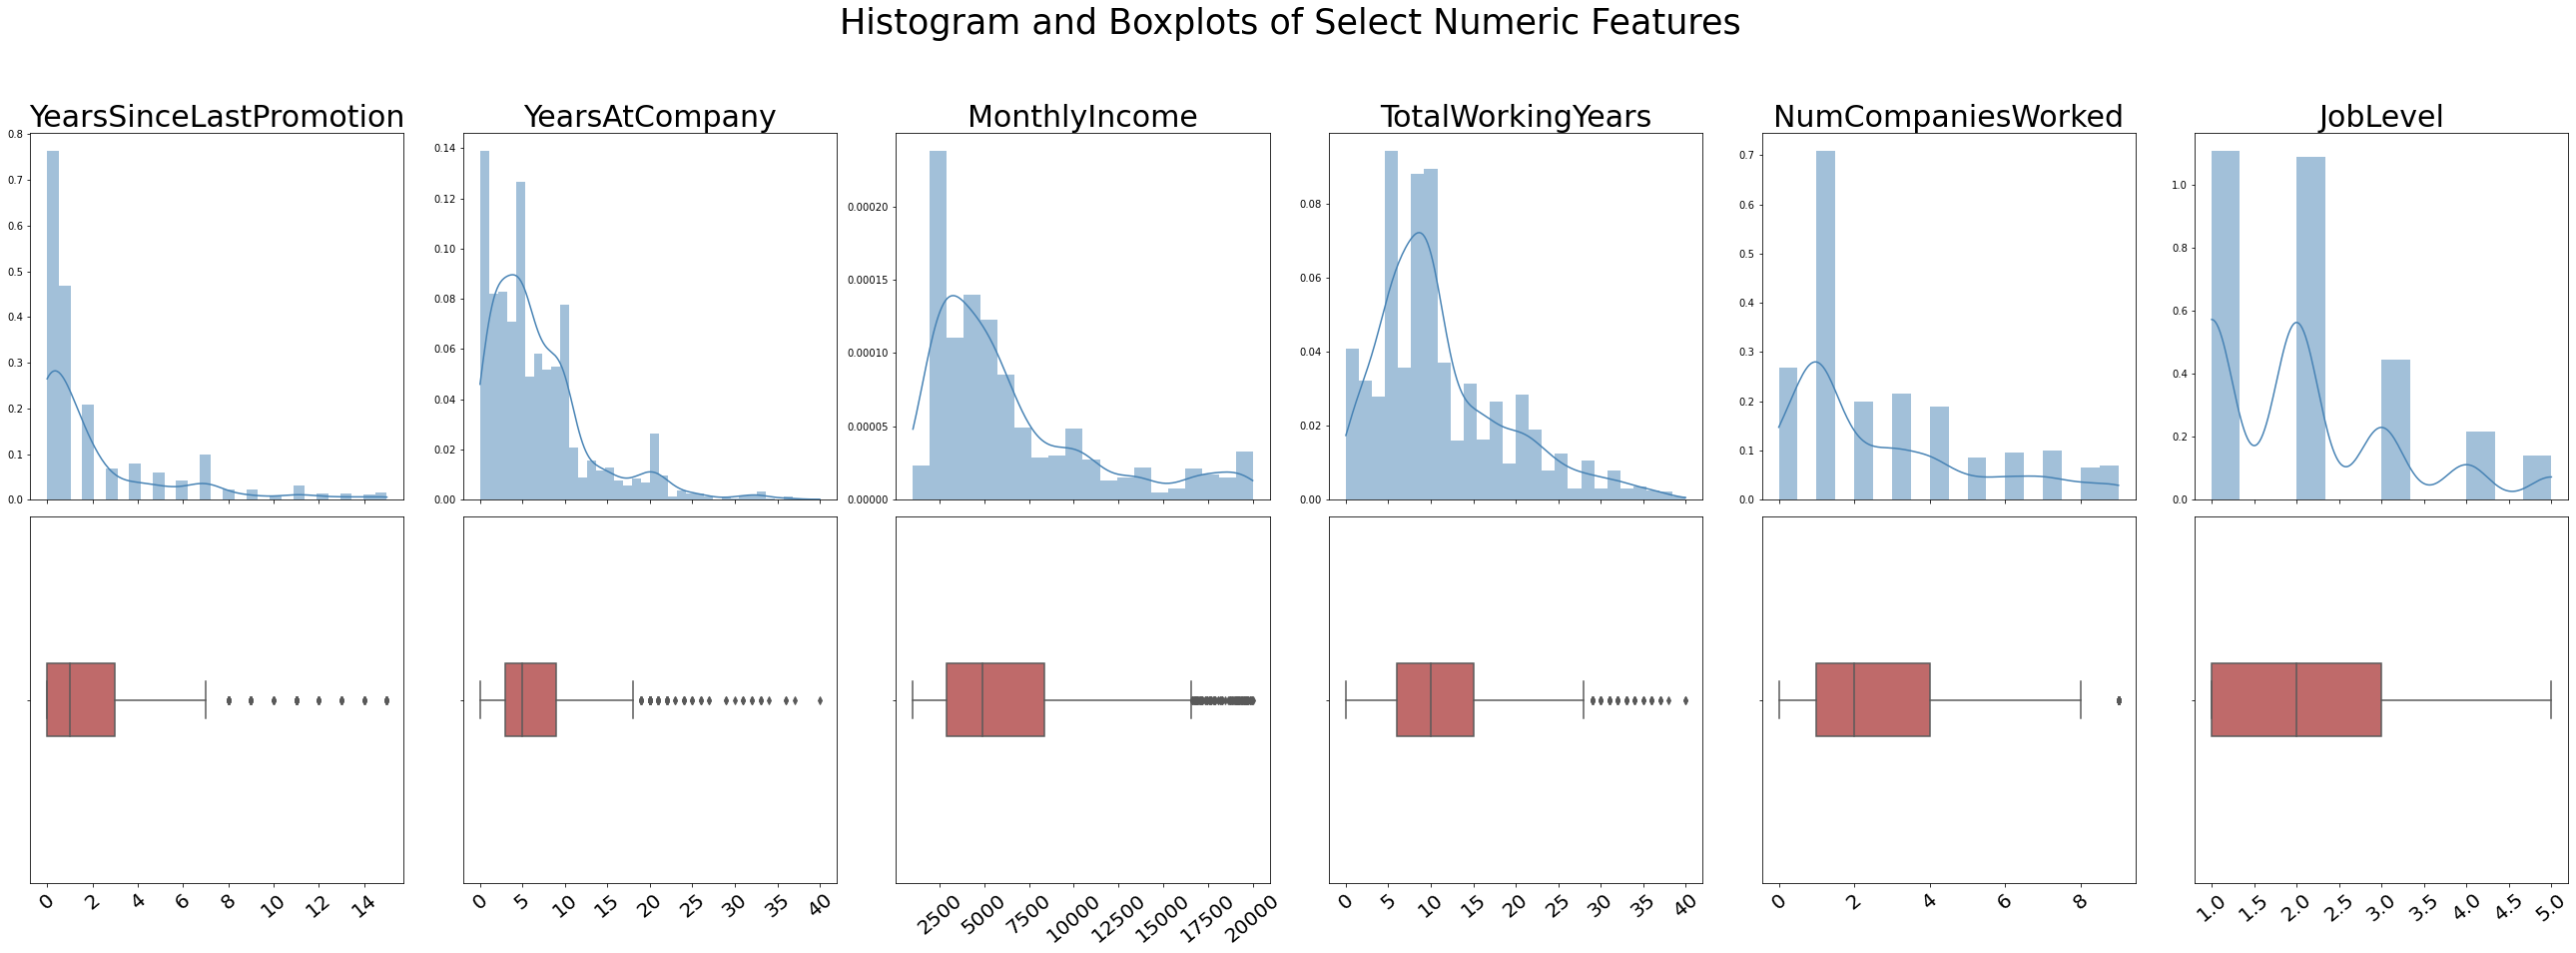

In [9]:
# Visualization of Summary Statistics of Select Numeric Variables
# Select 6 numeric variables with the highest value of skewness (absolute value)

# Compute the skewness values for the distribution of each numeric variable
skew_vals = skew(IBMData[numvars+ordvars], axis = 0, bias = False)
# Find the index of largest 6 absolute skewness values
indexvals = heapq.nlargest(6, range(len(skew_vals)), key = lambda x: abs(skew_vals[x]))
# Now select the numeric variables with largest absolute skewness values
select_floatvars = [(numvars + ordvars)[x] for x in indexvals]
# select_floatvars = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany']

plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
fig, ax = plt.subplots(2, len(select_floatvars), figsize = (6*len(select_floatvars), 6*2))
for i, item in enumerate(select_floatvars):

    # Plot the histogram first with kernel density estimates
    plt.subplot(2, len(select_floatvars), i+1)
    g = sns.histplot(IBMData, x = select_floatvars[i], stat = 'density', color = 'steelblue', kde = True)
    g.set_title(select_floatvars[i], fontsize = 30)
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_xticklabels([])
    
    # Then plot the boxplot with median values
    plt.subplot(2, len(select_floatvars), i+7)
    f = sns.boxplot(IBMData[item], color = 'indianred', width = 0.2, orient = 'v')  
    plt.draw()
    labels = [newitem.get_text() for newitem in f.get_xticklabels()]
    f.set_xlabel('')    
    f.set_xticklabels(labels, fontsize = 20, rotation = 40)
plt.tight_layout()    
plt.suptitle('Histogram and Boxplots of Select Numeric Features', fontsize = 35, y = 1.1)
plt.show()

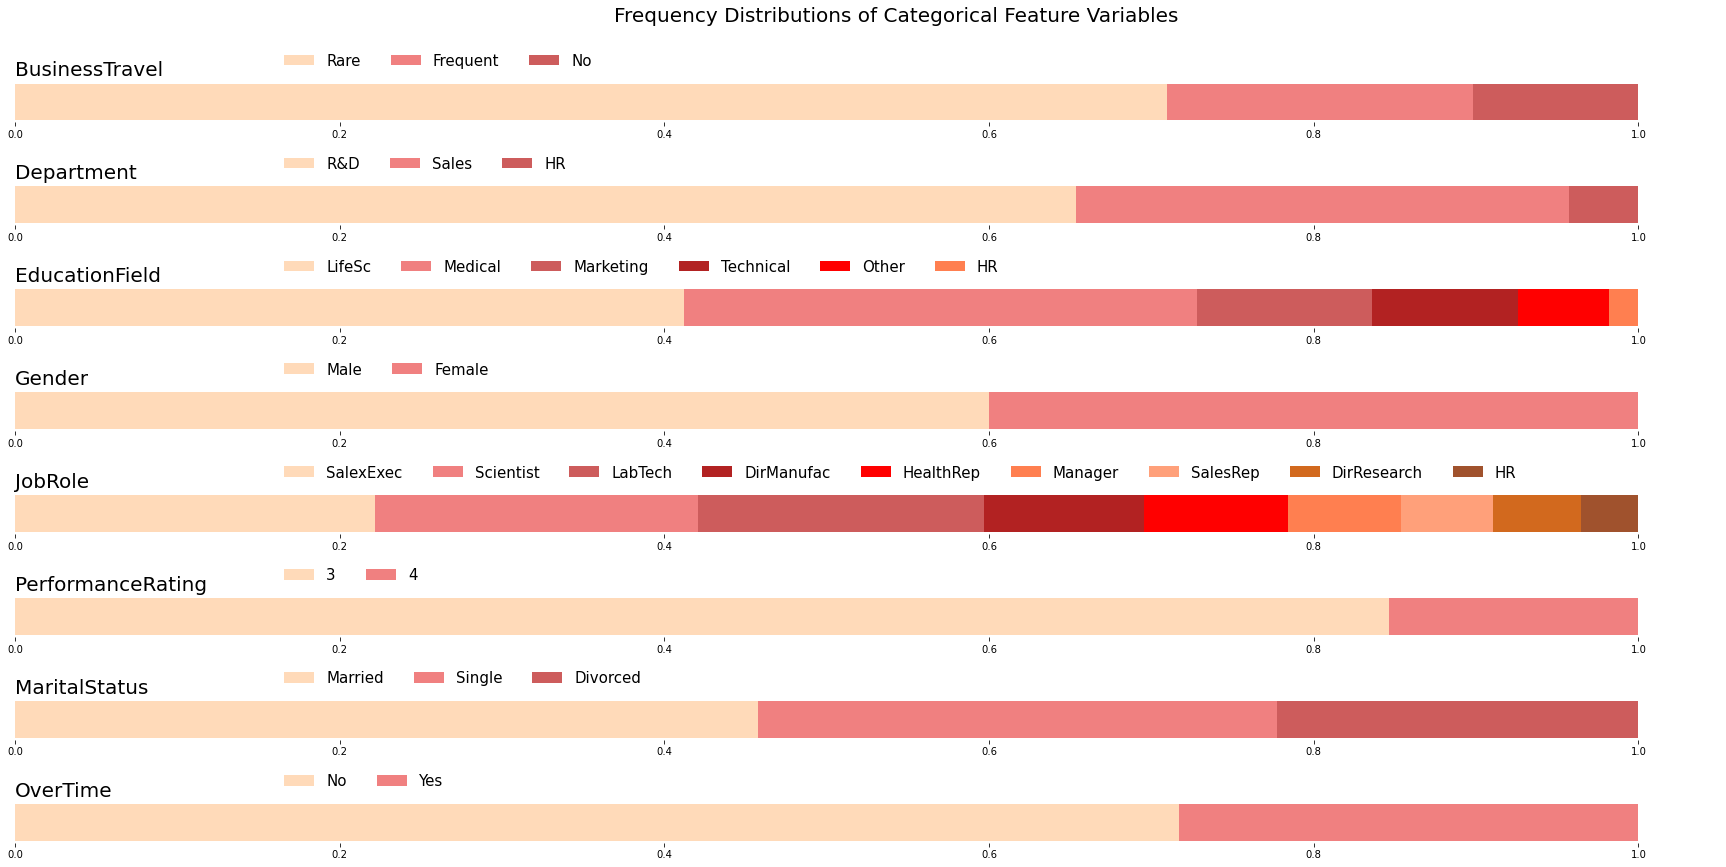

In [10]:
## Frequency Distributions of Select Categorical Variables

# Define a function which takes in the variable and then plots a frequency bar
def plot_catfreq(data, varname, axes, colors):
    
    # First create a dataframe which contains the frequency of the levels in the column defined by varname 
    df_grouped = pd.DataFrame(data[varname].value_counts()/len(data)).transpose()
    fields = df_grouped.columns.to_list()
    left = len(df_grouped)*[0]
    for idx, name in enumerate(fields):
        axes.barh(df_grouped.index, df_grouped[name], left = left, color = colors[idx], height = 0.5)
        left = left + df_grouped[name]
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['bottom'].set_visible(False)    
    axes.set_title(varname, loc = 'left', fontsize = 20)
    axes.legend(fields, ncol = data[varname].nunique(), frameon = False, bbox_to_anchor = ([0.15, 1.0, 0., 0.]), fontsize = 15)     
    axes.set_yticks([])  
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    
# Now define the parameters to pass to the function
colors = ['peachpuff', 'lightcoral','indianred','firebrick','red','coral','lightsalmon','chocolate','sienna','maroon']
fig, ax = plt.subplots(nrows = len(catvars), ncols = 1, figsize = (25, 1.5*len(catvars)))
for i, axes in enumerate(ax.flatten()):
    plot_catfreq(IBMData, catvars[i], axes, colors)
plt.suptitle('Frequency Distributions of Categorical Feature Variables', fontsize = 20, y = 1.0)    
plt.tight_layout()
plt.show()   

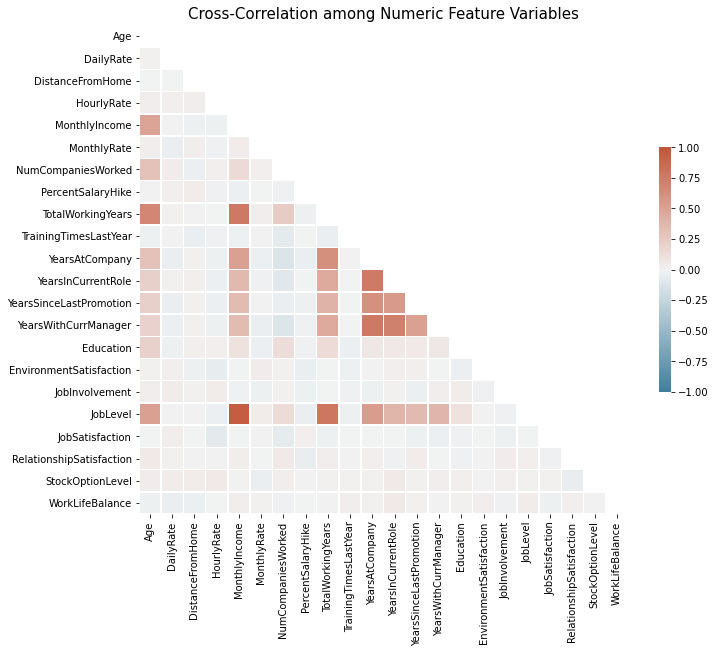

In [11]:
# Cross Correlations of Numeric Variables 

# First compute the correlation matrix
corr = IBMData[numvars + ordvars].corr()
# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))
fig, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
g = sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1.0, vmin = -1.0, center = 0, square = True, linewidth = 0.5, cbar_kws={"shrink": .5})
g.set_title('Cross-Correlation among Numeric Feature Variables', fontsize = 15);

In [12]:
# Summary Statistics of numeric variables grouped by categorical variables
# Here we show the mean, median, and standard deviations of each numeric variable grouped by select categorical variable
# Create a dataframe in which the rows are the variables, there are columns for each statistic and each group

grouping_var = 'Department'
stats = IBMData[numvars + ordvars + [grouping_var]].groupby('Department').describe()
statlist = ['mean', '50%', 'std']
statlist_changed = ['Mean', 'Median', 'Standard Deviation']
maxlevels = IBMData[grouping_var].nunique()

for counter, item in enumerate(numvars+ordvars):    
    newdf = pd.DataFrame()
    for stat in statlist:
        newdf = pd.concat([newdf, 
            stats.loc[:,item][stat].reset_index().pivot_table(index = [], columns = grouping_var, values = stat).reset_index(drop = True)], 
            axis = 1, ignore_index = False) 
    headers = list(itertools.chain.from_iterable(itertools.repeat(x, maxlevels) for x in statlist_changed))
    newdf.columns = pd.MultiIndex.from_tuples(list(zip(headers, newdf.columns)))
    newdf.insert(0, 'Variable', item)
    if(counter == 0):
            statdf = newdf.copy(deep = True)
    else:
        statdf = statdf.append(newdf, ignore_index = True)
pd.set_option('display.expand_frame_repr', False)
print('Summary Statistics of Numeric Variables by Department')
statdf     
    

Summary Statistics of Numeric Variables by Department


Variable          Mean                               Median                   Standard Deviation                          
                                        HR           R&D         Sales       HR      R&D    Sales                 HR          R&D        Sales
0                        Age     37.809525     37.042664     36.542603     37.0     36.0     35.0           9.226290     9.178965     9.032611
1                  DailyRate    751.539673    806.851196    800.275757    788.0    810.0    770.5         426.203949   402.513336   402.797455
2           DistanceFromHome      8.698413      9.144641      9.365471      6.0      7.0      7.0           8.115367     8.122044     8.086808
3                 HourlyRate     64.301590     66.167534     65.520180     59.0     66.0     66.0          21.562090    20.249281    20.354462
4              MonthlyIncome   6654.507812   6281.252930   6959.172852   3886.0   4374.0   5754.5        5788.732910  4895.834961  4058.739258
5                MonthlyRate  13492.984375  14284.866211  14489.793945  12832.0  14242.0  14419.5        7426.802734  7081.255371  7159.270020
6         NumCompaniesWorked      2.936508      2.733611      2.571749      2.0      2.0      1.0           2.861722     2.502874     2.432553
7          PercentSalaryHike     14.761905     15.291363     15.096413     14.0     14.0     14.0           3.617673     3.701128     3.576092
8          TotalWorkingYears     11.555555     11.342352     11.105381      9.0     10.0     10.0           8.855065     7.797327     7.597168
9      TrainingTimesLastYear      2.555556      2.792924      2.847534      2.0      3.0      3.0           1.201850     1.314103     1.244884
10            YearsAtCompany      7.238095      6.864724      7.284753      5.0      5.0      6.0           6.890185     6.024119     6.234885
11        YearsInCurrentRole      3.539683      4.155047      4.486547      2.0      3.0      3.0           2.827431     3.646045     3.660116
12   YearsSinceLastPromotion      1.777778      2.137357      2.354260      1.0      1.0      1.0           2.510908     3.200565     3.353357
13      YearsWithCurrManager      3.666667      4.084287      4.271300      3.0      3.0      3.0           2.923762     3.571031     3.643116
14                 Education      2.968254      2.899064      2.934978      3.0      3.0      3.0           0.983218     1.024293     1.031105
15   EnvironmentSatisfaction      2.682540      2.744017      2.679372      3.0      3.0      3.0           1.013225     1.102567     1.084259
16            JobInvolvement      2.746032      2.741935      2.701794      3.0      3.0      3.0           0.717708     0.714435     0.705259
17                  JobLevel      2.031746      1.977107      2.255605      1.0      2.0      2.0           1.379203     1.152667     0.927557
18           JobSatisfaction      2.603175      2.726327      2.751121      3.0      3.0      3.0           1.070720     1.101620     1.111103
19  RelationshipSatisfaction      2.888889      2.708637      2.695067      3.0      3.0      3.0           1.001791     1.070640     1.114288
20          StockOptionLevel      0.777778      0.804370      0.773543      1.0      1.0      1.0           0.869639     0.857092     0.840182
21           WorkLifeBalance      2.920635      2.725286      2.816144      3.0      3.0      3.0           0.725160     0.716964     0.675284

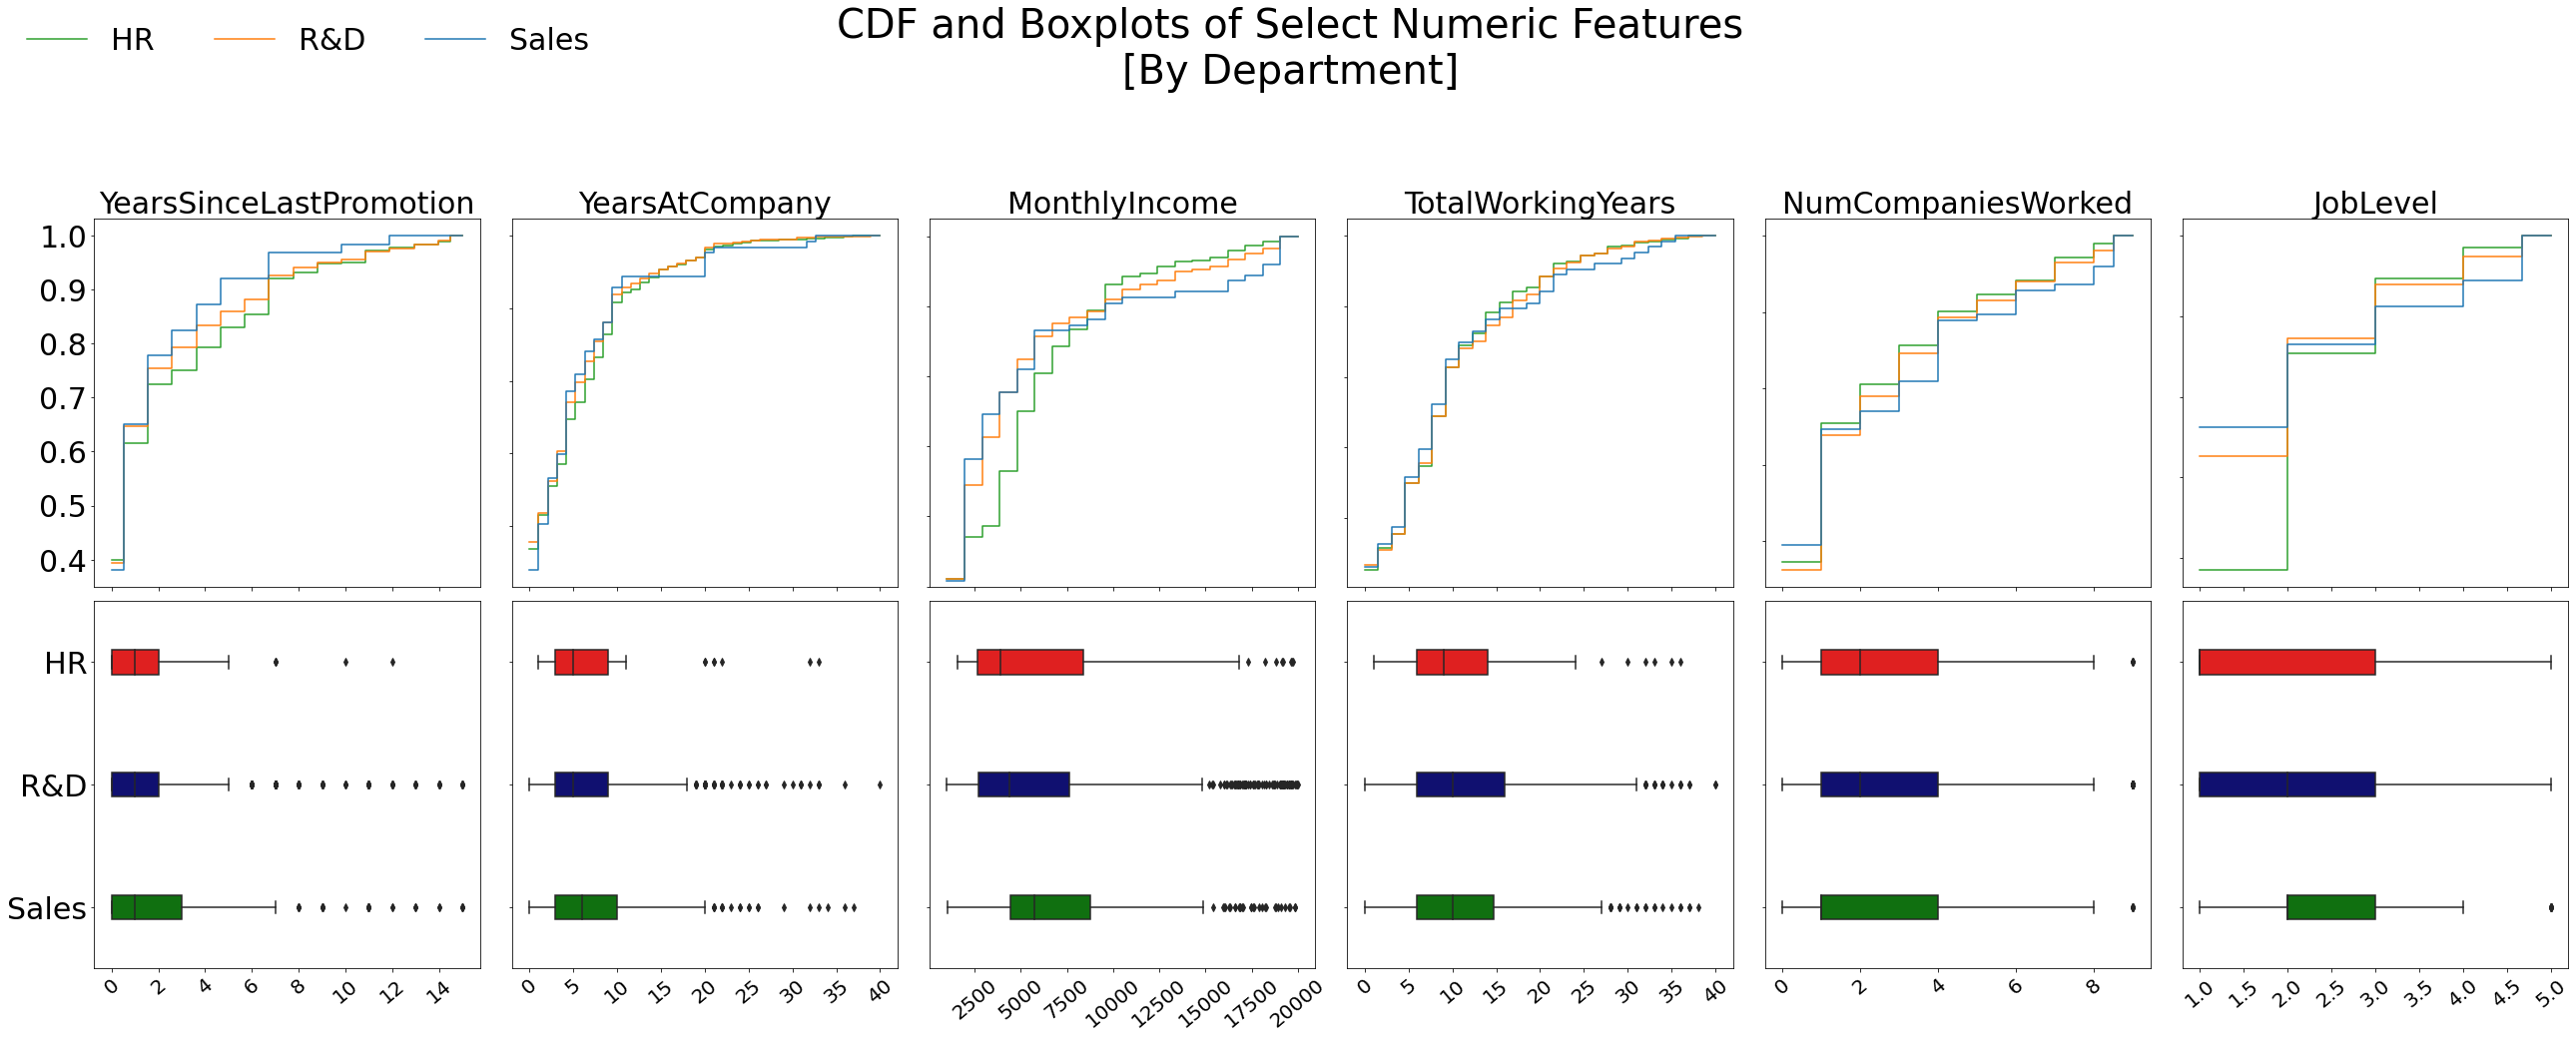

In [13]:
# Now plot histogram and boxplots of select numeric variables against department

plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
fig, ax = plt.subplots(2, len(select_floatvars), figsize = (6*len(select_floatvars), 6*2))
newlist = []
for i, item in enumerate(select_floatvars):

    # Plot the histogram first with kernel density estimates
    plt.subplot(2, len(select_floatvars), i+1)
    g = sns.histplot(IBMData, x = select_floatvars[i], hue = grouping_var, stat = 'density', element = 'step', 
                     color = ['red','navy','green'], cumulative = True, common_norm = False, fill = False, legend = False)
    plt.draw()
    g.set_title(select_floatvars[i], fontsize = 30)
    g.set_ylabel('')
    g.set_xlabel('')
    g.set_xticklabels([])
    if(i == 0):
        labels = [newitem.get_text() for newitem in g.get_yticklabels()]
        g.set_yticklabels(labels, fontsize = 30)
    else:
        g.set_yticklabels([])
    newlist.append(g)
    
    # Then plot the boxplot with median values
    plt.subplot(2, len(select_floatvars), i+7)
    f = sns.boxplot(data = IBMData, x = item, y = grouping_var, width = 0.2, palette = ['red','navy','green'])  
    plt.draw()
    labels = [newitem.get_text() for newitem in f.get_xticklabels()]
    f.set_xlabel('')    
    f.set_ylabel('')
    f.set_xticklabels(labels, fontsize = 20, rotation = 40)
    if(i == 0):
        labels = [newitem.get_text() for newitem in f.get_yticklabels()]
        f.set_yticklabels(labels, fontsize = 30)
    else:
        f.set_yticklabels([])
    
fig.legend(newlist, labels = ['HR','R&D','Sales'], loc = 'upper left', ncol = maxlevels, fontsize = 30)
plt.tight_layout()    
plt.suptitle('CDF and Boxplots of Select Numeric Features\n[By Department]', fontsize = 40, y = 1.2)
plt.show()

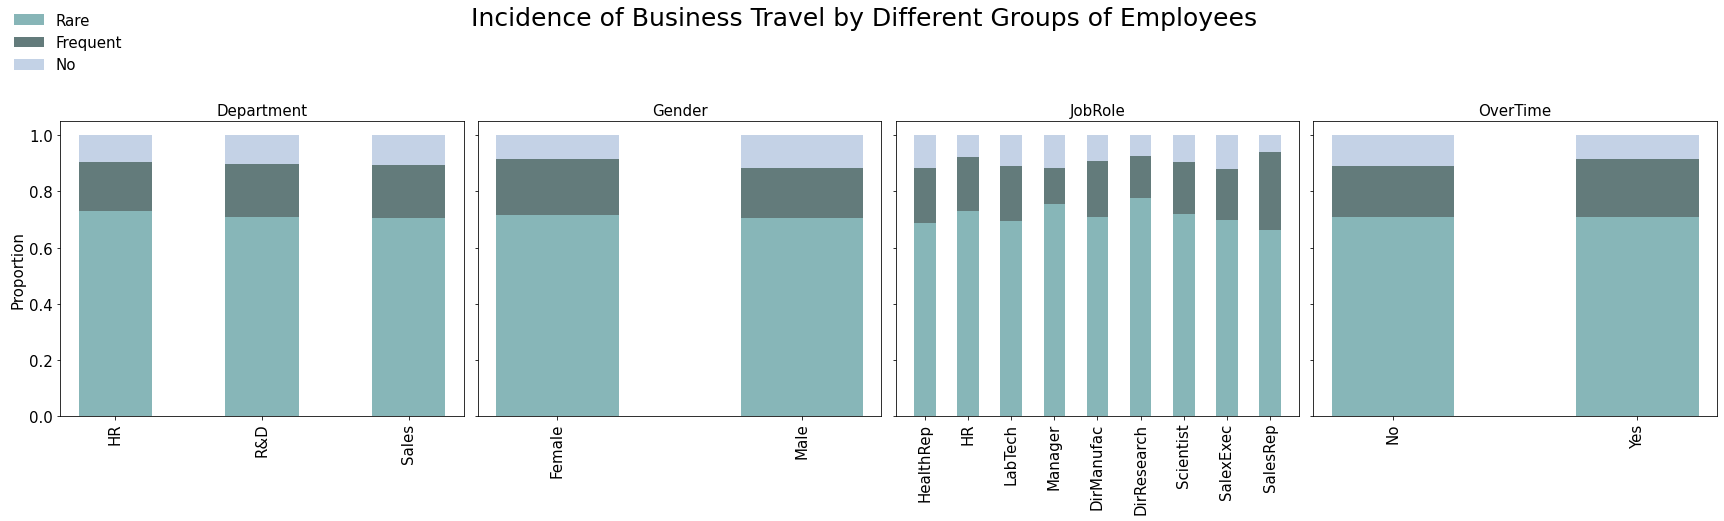

In [14]:
# Plot one or more categorical variables by another categorical variable:
# Categorize business travel by department, gender, jobrole, and overtime

select_catvars = ['BusinessTravel', 'Department', 'Gender', 'JobRole', 'OverTime']
maxlevels = max([IBMData[item].nunique() for item in select_catvars[1:]])

leglabels = []
fig, ax = plt.subplots(1, len(select_catvars)-1, figsize = (6*4, 6))
for counter, item in enumerate(select_catvars[1:]):
    
    newdf = pd.crosstab(IBMData[item], IBMData[select_catvars[0]], margins = True)
    newdf = newdf.iloc[:,:-1].div(newdf.iloc[:,-1], axis = 0).iloc[:-1,:].reset_index()
    newdf = pd.melt(newdf, id_vars = item, var_name = select_catvars[0], value_name = 'Proportion')
    
    plt.subplot(1, len(select_catvars)-1, counter+1)
    g = sns.histplot(newdf, x = item, hue = select_catvars[0], weights = 'Proportion', multiple = 'stack', 
                     shrink = 0.5, legend = False, palette = ['lightsteelblue','darkslategrey','cadetblue'])
    plt.draw()
    g.set_title(item, fontsize = 15)
    g.set_xlabel('')
    labels = [newitem.get_text() for newitem in g.get_xticklabels()]
    g.set_xticklabels(labels, fontsize = 15, rotation = 90)    
    if(counter == 0):
        labels = [newitem.get_text() for newitem in g.get_yticklabels()]
        g.set_yticklabels(labels, fontsize = 15)
        g.set_ylabel('Proportion', fontsize = 15)
    else:
        g.set_yticklabels([])
        g.set_ylabel('')
    leglabels.append(g)
fig.legend(leglabels, labels = ['Rare','Frequent','No'], loc = 'upper left', fontsize = 15, ncol = 1)
plt.tight_layout()
plt.suptitle('Incidence of Business Travel by Different Groups of Employees', fontsize = 25, y = 1.2);

#### (Step 3.c) Relationship Between Outcome and Feature Variables

* (A) Statistical Difference between Means of Numeric Features by Exit Status
* (B) Statistical Difference between Proportion of Exits in different levels of categorical features
* (C) Linear Probability Model (LPM) to estimate feature importance
* (D) Logistic Regression and Marginal Effects Computation to estimate feature importance

#### (A) Statistical Significance of Difference in Mean/Median of Numeric Variables by Exit Status

We first test for the statistical significance of the difference between 'average measures' of each numeric variable by exit status. 

The particular average measure we use for a numeric variable depends on whether, conditional on the exit status, the numeric variable has a normal distribution or a non-normal distribution. This can be checked using the Shapiro-Wilk test. We first conduct this test separately for each numeric variable by exit status, and if we cannot reject the null hypothesis of normality in the distribution of both exit types for a particular numeric variable, then we apply the standard two-sample t-test to check for the statistical significance of the difference between the means of each exit status. If the normality hypothesis fails for at least one exit status, we apply the Two-Sample Wilcoxon Test (also known as the Two-Sample Signed Test) which is a non-parameteric test of the statistical significance between the medians of the numeric variable by exit status. 

In [15]:
# Create two lists, one to store the normal numeric variables, and the other for non-normal numeric variables
normal_floatvars = []
nonnormal_floatvars = []
confidence_level = 0.05

for counter, item in enumerate(numvars+ordvars):
    if(shapiro(IBMData[IBMData['Attrition']==1].Age).pvalue > confidence_level and 
      shapiro(IBMData[IBMData['Attrition']==0].Age).pvalue > confidence_level):
        normal_floatvars.append(item)
    else:
        nonnormal_floatvars.append(item)
        
print('Numeric Features which follow normal distribution, conditional on both exit status:')
print(normal_floatvars)
print('\nNumeric Features which do not follow normal distribution, conditional on at least one exit status:')
print(nonnormal_floatvars)

if(len(normal_floatvars)==0):
    print('\n\nTherefore none of the numeric features follow normal distribution, conditional on both exit status.')
elif(len(nonnormal_floatvars)==0):
    print('\n\nTherefore none of the numeric features deviate from the normal distribution, for even one exit status.')

Numeric Features which follow normal distribution, conditional on both exit status:
[]

Numeric Features which do not follow normal distribution, conditional on at least one exit status:
['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']


Therefore none of the numeric features follow normal distribution, conditional on both exit status.


In [16]:
# Since no numeric feature follows normal distribution we will apply the one-sample Wilcoxon test to each numeric variable

wilcoxontest_df = pd.DataFrame()
pval_list = []

print('Conducting 2-sample Wilcoxon Signed Rank Test to check for statistical difference between distributions of numeric features by exit status...')
print('\nNull Hypothesis: The two distributions by exit status are not statistically different.\n')
for item in nonnormal_floatvars:
    pval_list.append(ranksums(IBMData[IBMData['Attrition']==1][item], IBMData[IBMData['Attrition']==0][item]).pvalue)
    
wilcoxontest_df['Numeric Feature'] = nonnormal_floatvars
wilcoxontest_df['pValue Wilcoxon Test'] = pval_list

def highlightcells(s):
    if(s['pValue Wilcoxon Test'] < confidence_level):
        return ['background-color: tomato']*wilcoxontest_df.shape[1]
    else:
        return ['background-color: white']*wilcoxontest_df.shape[1]
    
print('\nTable below highlights numeric features for which distributions are statistically different by exit status:')    
wilcoxontest_df.style.apply(highlightcells, axis = 1)   

Conducting 2-sample Wilcoxon Signed Rank Test to check for statistical difference between distributions of numeric features by exit status...

Null Hypothesis: The two distributions by exit status are not statistically different.


Table below highlights numeric features for which distributions are statistically different by exit status:


,Numeric Feature,pValue Wilcoxon Test
0,Age,0.000000
1,DailyRate,0.028999
2,DistanceFromHome,0.002473
3,HourlyRate,0.797588
4,MonthlyIncome,0.000000
5,MonthlyRate,0.558692
6,NumCompaniesWorked,0.254566
7,PercentSalaryHike,0.368351
8,TotalWorkingYears,0.000000
9,TrainingTimesLastYear,0.058464


We now test for the statistical significance of the difference in the proportion of exits between any two levels of a cateogorical variable, and we do this or each categorical variable separately. This is implemented using the Marascuillo procedure, explained below. 


Feature: "Gender" ----- No Statistical Difference in proportion of exits between levels.

Feature: "OverTime" ----- Statistical Difference Detected in proportion of exits between some levels.


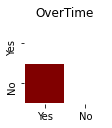


Feature: "PerformanceRating" ----- No Statistical Difference in proportion of exits between levels.

Feature: "BusinessTravel" ----- Statistical Difference Detected in proportion of exits between some levels.


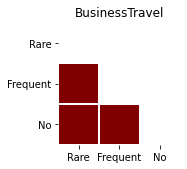


Feature: "Department" ----- Statistical Difference Detected in proportion of exits between some levels.


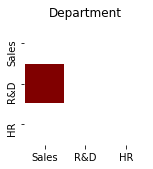


Feature: "MaritalStatus" ----- Statistical Difference Detected in proportion of exits between some levels.


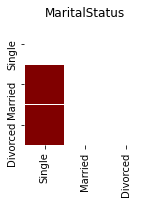


Feature: "EducationField" ----- No Statistical Difference in proportion of exits between levels.

Feature: "JobRole" ----- Statistical Difference Detected in proportion of exits between some levels.


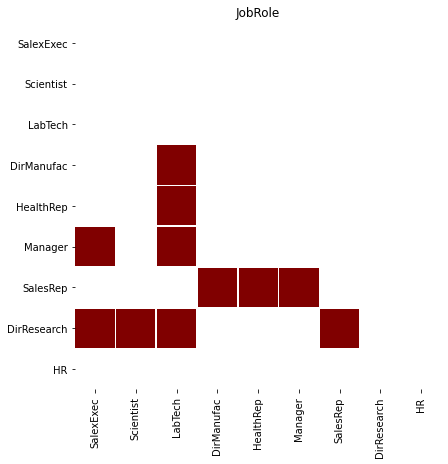

In [31]:
# Define a function which computes the significance level of the proportion between two groups

def compute_significance_propdiff(x, y, alpha, dof):
    
    #print(len(x), len(y), sum(x), sum(y))
    zval = np.sqrt(chi2.ppf(1.-alpha/2, dof))*np.sqrt(sum(x)*(len(x)-sum(x))/len(x)**3 + sum(y)*(len(y)-sum(y))/len(y)**3)
    if(abs(sum(x)/len(x) - sum(y)/len(y)) < zval):
        return 0.
    else:
        return 1.
    
# Arrange the catvars list in ascending order of the number of levels
numlevels = [IBMData[item].nunique() for item in catvars]
catvars = [x for (index, x) in sorted(zip(numlevels, catvars))]

for item in catvars:    
    
    # Define a dataframe to store the significance outcomes
    numlevels = IBMData[item].nunique()
    newframe = np.zeros((numlevels, numlevels))
    
    # Iterate over each level of the variable
    levels = IBMData[item].unique().to_list()
    for c1, l1 in enumerate(levels):
        for c2, l2 in enumerate(levels):
            if(c1 > c2):
                newframe[c1, c2] = compute_significance_propdiff(IBMData[IBMData[item]==l1]['Attrition'], 
                                                                 IBMData[IBMData[item]==l2]['Attrition'], 
                                                                 confidence_level, numlevels-1)
    # Plot if at least one comparison yields significane differences in the proportions            
    if(np.any(newframe > 0.5)):
        print('\nFeature: "'+item+'" ----- Statistical Difference Detected in proportion of exits between some levels.')
        newframe = pd.DataFrame(newframe)
        newframe.columns = levels
        newframe.index = levels
        #print(newframe)            

        mask = newframe < 0.5
        fig, ax = plt.subplots(figsize = (0.75*numlevels,0.75*numlevels))    
        g = sns.heatmap(newframe, mask = mask, cmap = ['maroon','antiquewhite'], 
                        square = True, linewidth = 0.5, cbar = False)
        g.set_title(item)
        plt.show()
    else:
        print('\nFeature: "'+item+'" ----- No Statistical Difference in proportion of exits between levels.')

        
    
    

The analyses above shows that proportions of exits are statistically different at least between some levels for the categorical features: JobRole, MaritalStatus, Department, BusinessTravel, and OverTime. There is no statistical difference in the proportion of exits between any levels of other categorical variables. 

#### Linear Probability Model (LPM) to estimate feature importance in exit decision

In this analysis, we regress the binary 'Attrition' variable on a linear function of all features and then estimate the coefficients for each feature. For each categorical variable we will drop one level, which we will call the 'base level'. The coefficients on each feature (or each level of categorical features) can be interpreted as the marginal effect of that feature (or level) on the employee's exit decision. 

We will also conduct the same analyses with a simple logistic regression and then compute the marginal effects of each feature (level). To ensure comparability across features (with different scales) we will standardize all numeric features and retain categorical features as they are. 

In [80]:
scaler = StandardScaler()

# Scale only the numeric variables and retain the categorical variables as such
IBMData_numscaled = pd.concat([pd.DataFrame(scaler.fit(IBMData[numvars + ordvars]).transform(IBMData[numvars + ordvars]), 
                                           columns = IBMData[numvars + ordvars].columns), 
                       IBMData[catvars + ['Attrition']]], axis = 1)
print('Shape of old dataframe: {}'.format(IBMData.shape))
print('Shape of scaled dataframe: {}'.format(IBMData_numscaled.shape))

Shape of old dataframe: (1470, 31)
Shape of scaled dataframe: (1470, 31)


In [101]:
# Define the base-levels to be dropped for each categorical feature as a dictionary
# Choice of base-level is generally not arbitrary. We drop the level which we believe will have the least impact from among all levels
baselevel_dict = {'Gender':'"Female"', 
                 'OverTime':'"No"', 
                 'PerformanceRating':3,
                 'BusinessTravel':'"No"',
                 'Department':'"HR"', 
                 'MaritalStatus':'"Divorced"',
                 'EducationField':'"Other"',
                 'JobRole':'"HR"'}

# Now generate the specification for LPM as a string
formula = 'Attrition ~ '
for item in (numvars + ordvars):
    formula = formula + str(item) + ' + '
for counter, item in enumerate(catvars):
    if(counter == len(catvars)-1):
        formula = formula + 'C(' + str(item) + ', Treatment(reference = ' + str(baselevel_dict[item]) + '))'
    else:
        formula = formula + 'C(' + str(item) + ', Treatment(reference = ' + str(baselevel_dict[item]) + ')) + '
            
# Now fit the LPM to the scaled data
LPM_Inference = smf.ols(data = IBMData_numscaled, formula = formula).fit()

Now we arrange these coefficients by ascending order of their absolute values, to find out which features have the highest contribution to exit decisions. We also drop the intercept in this plot. 

In [115]:
# Define a function that can take the transformed feature name and then convert it into more interpretable name

# Define a function which takes in a dataframe with feature names, actual effects, and errors
# and sorts the dataframe by absolute value of effects and corrects the feature names.




def modify_frame(oldframe, effect_var, name_var):
    
    # Sort rows based on absolute value of effect_var
    newframe = oldframe.iloc[oldframe[effect_var].abs().argsort()]
    
    # Now apply a function to each row of feature name to modify the name
    newframe[name_var] = newframe[name_var].apply(lambda x: 
                                                  re.search(r'\((.+?),', x).group(1)+'_'+re.search(r'\.(.+?)\]',x).group(1) 
                                                 if re.search(r'\((.+?),', x) else x)
    
    return newframe

LPM_df = pd.DataFrame()
LPM_df = pd.concat([LPM_Inference.params, LPM_Inference.conf_int(alpha = confidence_level)], axis = 1).reset_index()
LPM_df.columns = ['Feature', 'Effect', 'CI_low', 'CI_high']
LPM_df['Errors'] = (LPM_df['CI_high'] - LPM_df['CI_low'])/2.
LPM_df = LPM_df[LPM_df.Feature != 'Intercept']
LPM_df.drop(['CI_low', 'CI_high'], axis = 1, inplace = True)
LPM_df = modify_frame(LPM_df, 'Effect', 'Feature')
 

print('Features with 10 largest contributions to exit decisions are:\n')
LPM_largest = LPM_df['Feature'][-10:].to_list()
[LPM_largest[len(LPM_largest)-1-item] for item in np.arange(len(LPM_largest))]

Features with 10 largest contributions to exit decisions are:



['JobRole_DirResearch',
 'JobRole_HealthRep',
 'OverTime_Yes',
 'JobRole_DirManufac',
 'JobRole_Scientist',
 'JobRole_Manager',
 'BusinessTravel_Frequent',
 'EducationField_HR',
 'Department_R&D',
 'EducationField_Technical']

In [211]:
# Now plot a graph

# fig, ax = plt.subplots(figsize = (82, 40))
# LPM_df.plot(x = 'Feature', y = 'Effect', yerr = 'Errors', kind = 'bar', color = 'none', capsize = 0, 
#            ax = ax, ecolor = 'royalblue', fontsize = 20)
# ax.scatter(x = pd.np.arange(LPM_df.shape[0]), marker = 'o', s = 300, y = LPM_df['Effect'], color = 'black')
# ax.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 5)
# ax.set_xticklabels(LPM_df['Feature'], fontsize = 50)
# ax.tick_params(axis = 'y', labelsize = 50)
# ax.set_xlabel('')
# ax.text(0, 0.375, 'Standard error spikes represent 95% CIs', fontsize = 60)
# plt.suptitle('Effects of Features on Probability of Attrition in Linear Probability Model', fontsize = 80, y = 0.99);

#### Logistic Regression Model to estimate Feature Importance in Explaining Attrition

Next, we implement a simple logistic regression model to estimate the effects of each feature (or levels of categorical variables) on the probability of attrition. Since logistic regression model is a non-linear model, we have to estimate the marginal effects of each feature (or levels or categorical variables) and then we can compare them to the estimates from Linear Probability Model (LPM). 

In [200]:
IBMData_numscaled_dummied = pd.get_dummies(IBMData_numscaled, drop_first = False)
IBMData_numscaled_dummied.drop([
    str(key)+'_'+re.search(r'"(.+?)"', val).group(1) if type(val) is str else str(key)+'_'+str(val) 
    for key, val in baselevel_dict.items()], axis = 1, inplace = True)
#print(IBMData_numscaled_dummied.shape)

In [201]:
Logit_Inference = LogisticRegression(penalty = 'none').fit(IBMData_numscaled_dummied.drop(['Attrition'], axis = 1), IBMData_numscaled_dummied['Attrition'])

In [208]:
# Now we compute the marginal effects of the variables using the derivative method

Logit_df = pd.DataFrame()
a = np.sum(IBMData_numscaled_dummied.drop(['Attrition'], axis = 1)*Logit_Inference.coef_[0], axis = 1)
Logit_df['Effect'] = np.mean(np.exp(-a)/(1. + np.exp(-a))**2)*Logit_Inference.coef_[0]
Logit_df['Feature'] = IBMData_numscaled_dummied.drop(['Attrition'], axis = 1).columns.to_list()
Logit_df = modify_frame(Logit_df, 'Effect', 'Feature')

print('Features with 10 largest contributions to exit decisions are:\n')
Logit_largest = Logit_df['Feature'][-10:].to_list()
[Logit_largest[len(Logit_largest)-1-item] for item in np.arange(len(Logit_largest))]

Features with 10 largest contributions to exit decisions are:



['JobRole_DirResearch',
 'JobRole_HealthRep',
 'JobRole_DirManufac',
 'JobRole_Manager',
 'JobRole_Scientist',
 'OverTime_Yes',
 'BusinessTravel_Frequent',
 'Department_R&D',
 'JobRole_SalexExec',
 'JobRole_LabTech']

In [212]:
# fig, ax = plt.subplots(figsize = (82, 40))
# Logit_df.plot(x = 'Feature', y = 'Effect', kind = 'bar', color = 'none', ax = ax, fontsize = 20)
# ax.scatter(x = pd.np.arange(Logit_df.shape[0]), marker = 'o', s = 300, y = Logit_df['Effect'], color = 'black')
# ax.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 5)
# ax.set_xticklabels(Logit_df['Feature'], fontsize = 50)
# ax.tick_params(axis = 'y', labelsize = 50)
# ax.set_xlabel('')
# ax.set_ylim(-0.5, 0.4)
# ax.text(0, 0.375, 'Standard error spikes represent 95% CIs', fontsize = 60)
# plt.suptitle('Effects of Features on Probability of Attrition in Logistic Regression Model', fontsize = 80, y = 0.99);

Now merge the two effects frames and then plot jointly the effects.


In [225]:
LPMLogit_df = LPM_df.drop(['Errors'], axis = 1).merge(Logit_df, on = 'Feature', suffixes = ['_LPM', '_Logit'])
LPMLogit_df = LPMLogit_df.iloc[LPMLogit_df.Effect_LPM.abs().argsort()]

maxlimit = max(max(LPMLogit_df.Effect_LPM.abs()), max(LPMLogit_df.Effect_Logit.abs()))

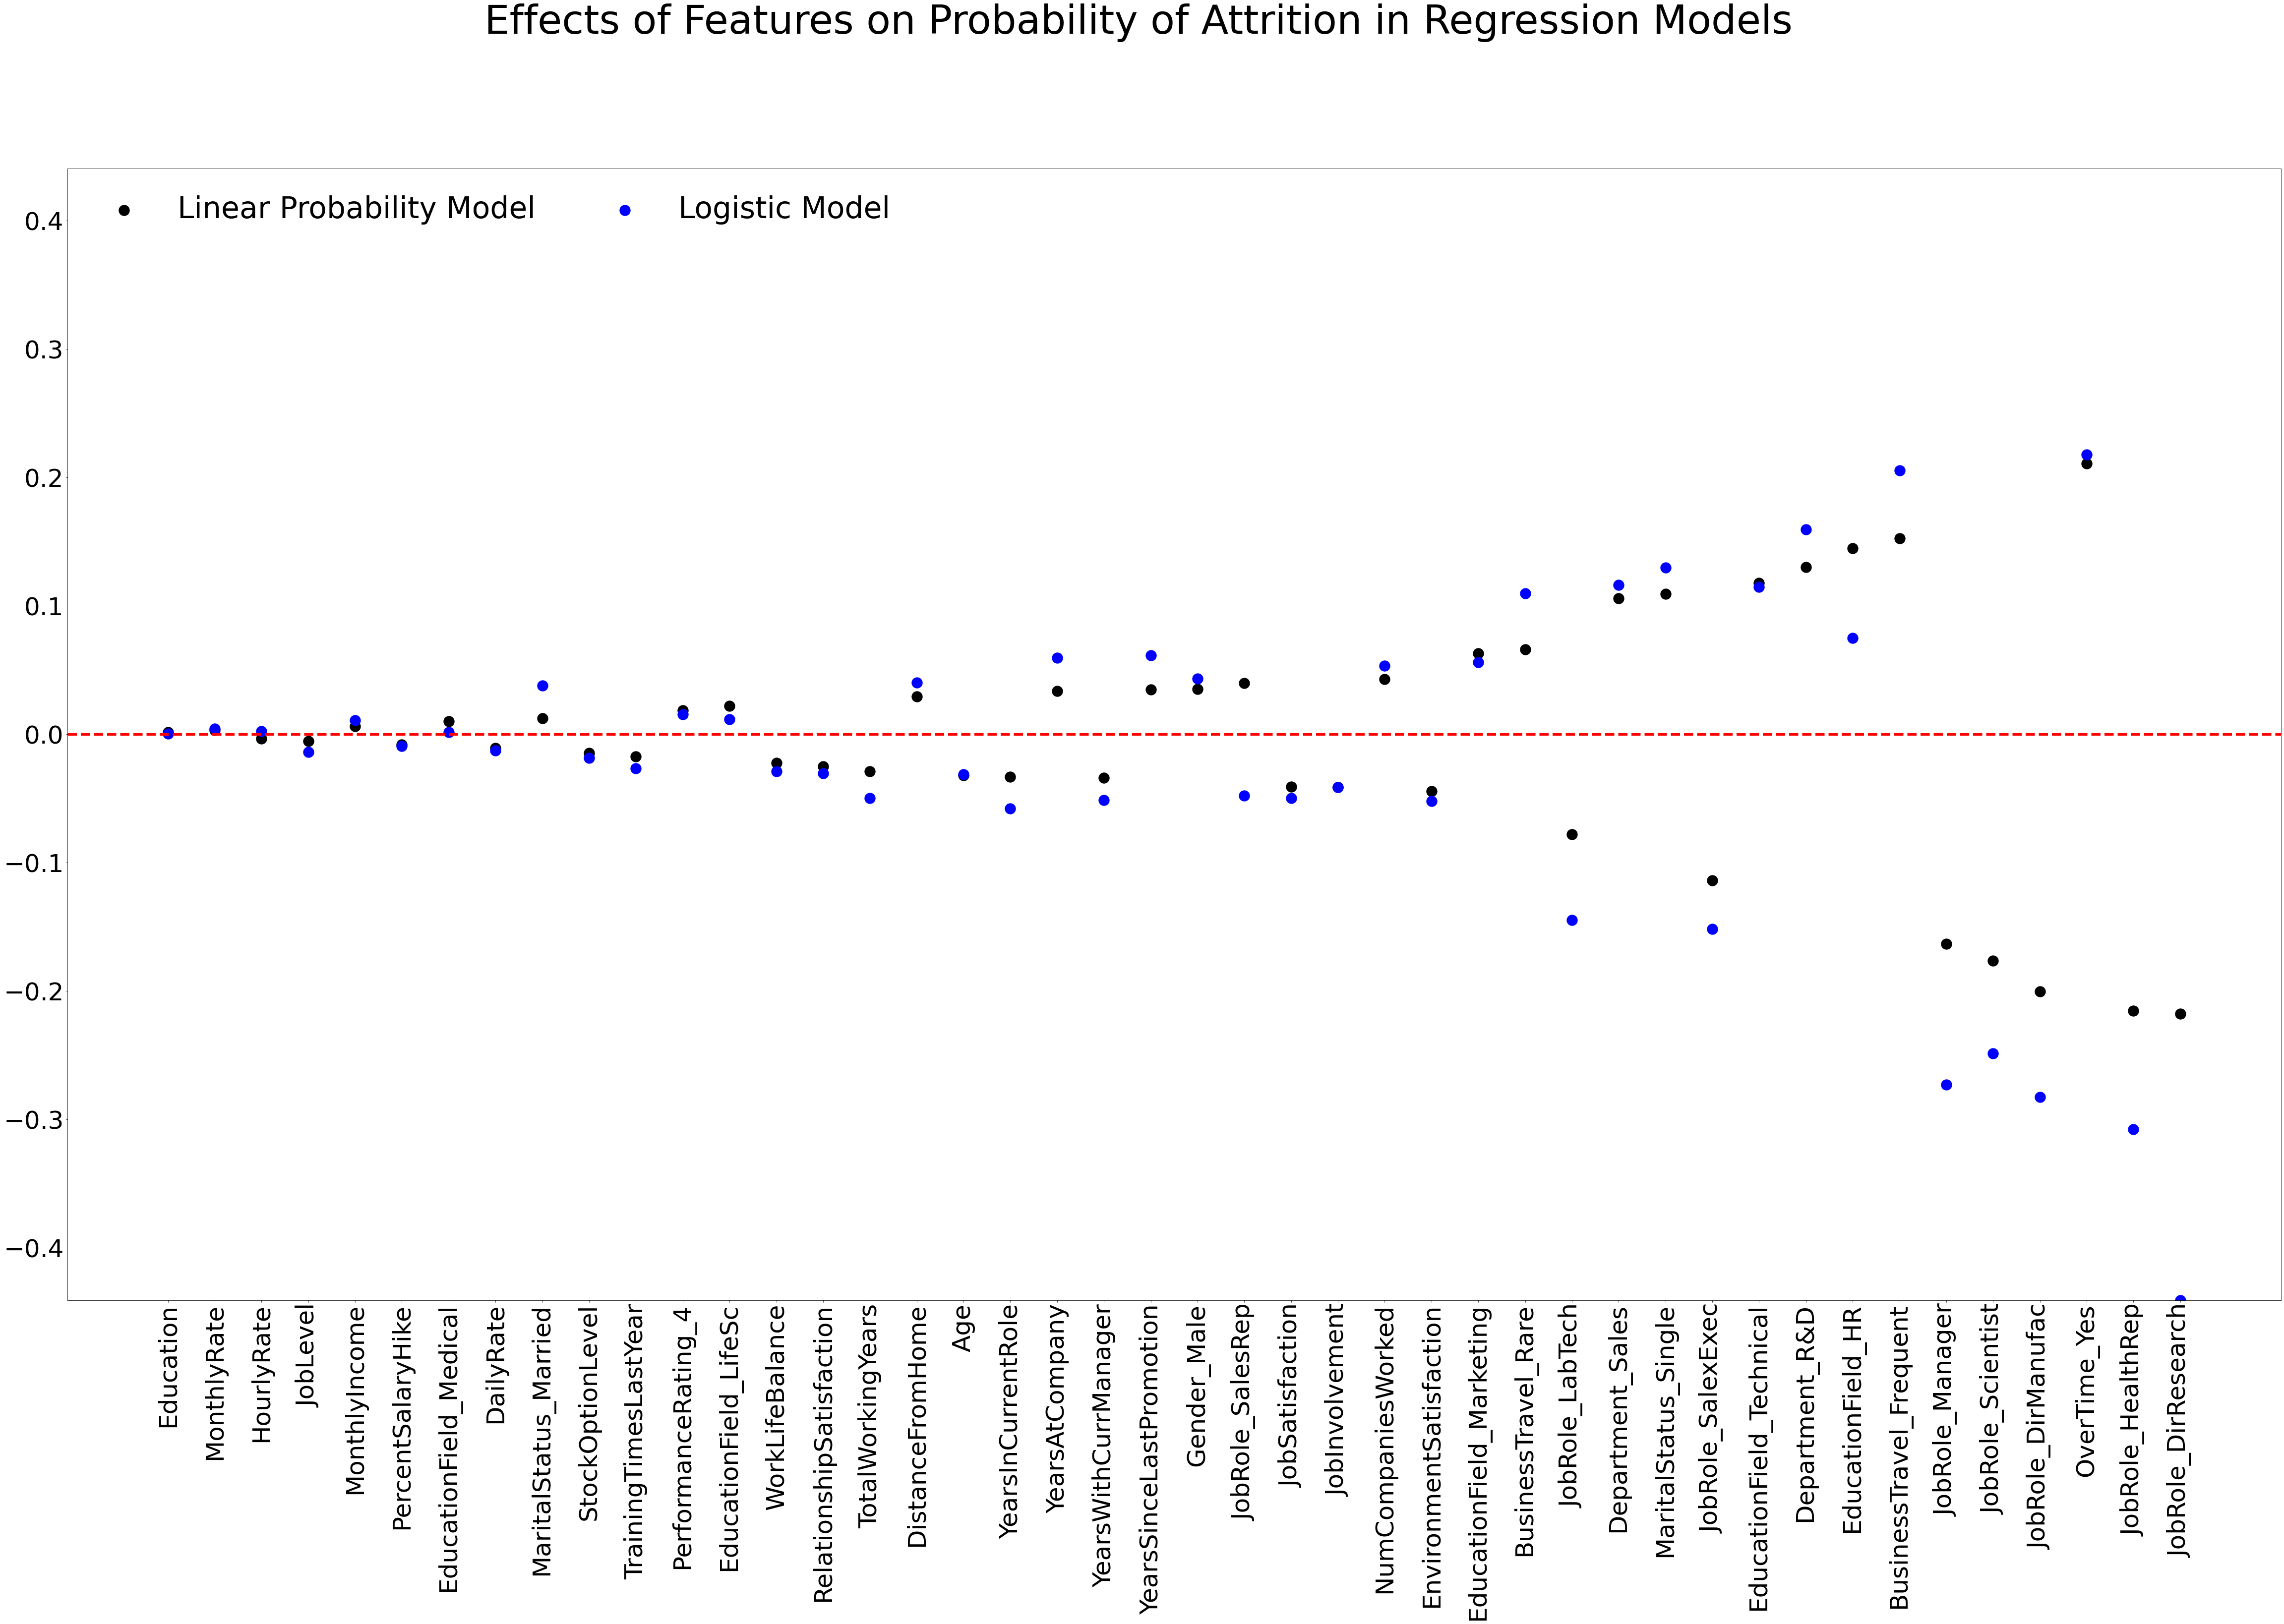

In [248]:
fig,ax = plt.subplots(figsize = (80,42))
ax.scatter(x = LPMLogit_df['Feature'], marker = 'o', s = 500, y = LPMLogit_df['Effect_LPM'], color = 'black', label = 'Linear Probability Model')
ax.scatter(x = LPMLogit_df['Feature'], marker = 'o', s = 500, y = LPMLogit_df['Effect_Logit'], color = 'blue', label = 'Logistic Model')
ax.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 5)
ax.set_xticklabels(LPMLogit_df['Feature'], fontsize = 50, rotation = 90)
ax.tick_params(axis = 'y', labelsize = 50)
ax.set_xlabel('')
ax.set_ylim(-maxlimit, maxlimit)
ax.legend(loc = 'upper left', ncol = 2, prop={'size': 60})
plt.suptitle('Effects of Features on Probability of Attrition in Regression Models', fontsize = 80, y = 0.99);

The plot above shows that the estimates are very close for both LPM and Logistic Models. This implies that features which are important determinants of Attrition in LPM are also important determinants in a Logistic Model.